# Blending of Parking and Charging Data

Here we blend the APCOA Parking Data and ACN Charging Data using collaborative filtering. The rationale is as follows:

- ACN data caputres only charging events, not total EVCC occupancy. Hence it is not suitable for sizing applications. Yet, it is currently the most comprehensive publicly available dataset that captures charging demand at semi-publice workplace facilities.
- For sizing we need full parking cluster occupation along with estimated charging demand per parker. Therefore, we blend both datasets using collaborative filtering techniques.

In [29]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# ML/Clustering stuff
#from sklearn.preprocessing import StandardScaler
#from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings(action="ignore")

In [30]:
# CONFIG

DATA_PATH = "/Volumes/karsten.schroer@uni-koeln.de/Uni/Research/04_CASE_Clustered_EV_Charging/"
OUT_PATH = ""

In [31]:
parking_sessions = pd.read_csv(DATA_PATH+"Parking_Data/Parking_Data_Combined_CLEAN.csv")
charging_sessions = pd.read_csv(DATA_PATH+"ACN_Caltech_Charging_Data/acndata_sessions_COMBINED_API.csv")
charging_sessions.dropna(inplace=True)

### Blending via Collaborative Filtering

We basically match expected charging demand to parking transaction using an algo we have fitted on charging sessions data. As is typical for collaborative filtering, there is no real test set here. Instead, the best we can do is select some of the hyperparameter based on a train-test split of the charging session data.

We use a memory-based approach which makes a prediction for the new observations in the parking dataset based on their similarity with the "labeled" data in the ACN charging dataset. See here: https://en.wikipedia.org/wiki/Collaborative_filtering#Memory-based. Also see here: https://towardsdatascience.com/various-implementations-of-collaborative-filtering-100385c6dfe0

#### KNN Approach

In [32]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [33]:
#cluster_feat = ["EntryMin_sin","EntryMin_cos","MinutesStay"]
knn_feat = ["EntryMin_sin","EntryMin_cos","MinutesStay"]
outputs = ['userInputs_WhPerMile', 'userInputs_kWhRequested','userInputs_milesRequested']

TODO: Which number of neighbors k is a good value?

In [34]:
# YOUR CODE HERE:

def find_knn (x,y,max_k):
    
    err_train = [] 
    err_test = []
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3,random_state=10)

    for n in np.arange(1,max_k):

        # fit model
        KNN_reg = KNeighborsRegressor(n_neighbors=n)
        KNN_model = KNN_reg.fit(x_train, y_train)


        # compute errors
        err_train.append(mean_absolute_error(KNN_model.predict(x_train), y_train))
        err_test.append(mean_absolute_error(KNN_model.predict(x_test), y_test))
        
    plt.figure(figsize = (8,6))
    plt.plot(np.arange(1,max_k), err_train,np.arange(1,max_k), err_test)
    plt.legend(["Training", "Validation"])
    plt.xlabel("Number of neighbors")
    plt.ylabel("MAE")
    #plt.ylim((0,1))
    plt.show()



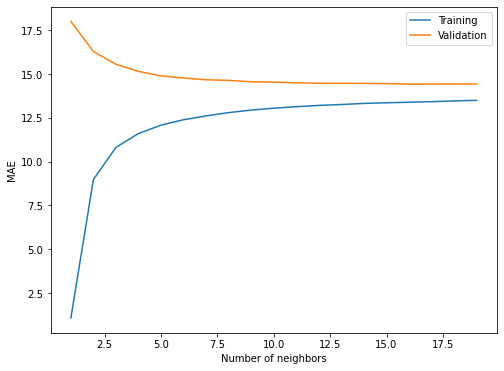

In [35]:
x=charging_sessions[knn_feat]
y=charging_sessions['userInputs_kWhRequested']
find_knn (x,y,max_k=20)

We select k=12 from this analysis

__KNN Blending__

In [36]:
metric = "minkowski" # the distance metric to compute nearest neigbors!
 
charging_knn = KNeighborsRegressor(n_neighbors=12, metric=metric)
charging_knn.fit(charging_sessions[knn_feat], charging_sessions[outputs])

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=12, p=2,
                    weights='uniform')

In [37]:
parking_sessions[outputs] = charging_knn.predict(parking_sessions[knn_feat])

__Feasibility Checks__

Ensure that requested charge is feasible using 22kW Charging Stations

In [38]:
parking_sessions["MaxFeasible_kwhRequested"] = 22*(parking_sessions["HoursStay"])
parking_sessions["final_kWhRequested"] = parking_sessions.apply(lambda x: x.userInputs_kWhRequested if x.userInputs_kWhRequested<x.MaxFeasible_kwhRequested else x.MaxFeasible_kwhRequested,axis=1)

In [39]:
parking_sessions.columns

Index(['Unnamed: 0', 'EntryDateTime', 'ExitDateTime', 'HoursStay',
       'MinutesStay', 'RevenueAmount', 'SiteID', 'Year', 'EntryMFM', 'ExitMFM',
       'EntryDate', 'ExitDate', 'EntryHour', 'ExitHour', 'EntryHour_sin',
       'EntryHour_cos', 'EntryMin_sin', 'EntryMin_cos', 'ExitHour_sin',
       'ExitHour_cos', 'ExitMin_sin', 'ExitMin_cos', 'EntryDayOfWeek',
       'EntryWeekday_yn', 'EntryHoliday_yn', 'userInputs_WhPerMile',
       'userInputs_kWhRequested', 'userInputs_milesRequested',
       'MaxFeasible_kwhRequested', 'final_kWhRequested'],
      dtype='object')

__Remove Energy Demand for Grace Period and Extreme Short Stays__

Vehicles that stay for only short periods are not expected to make a charging request

In [40]:
limit=15
parking_sessions["final_kWhRequested"] = parking_sessions.apply(lambda x: x.final_kWhRequested if x.MinutesStay>limit else 0,axis=1)

In [43]:
len(parking_sessions[parking_sessions["MinutesStay"]<limit])/len(parking_sessions)

0.08023326525296468

__Save Data__

In [44]:
parking_sessions.to_csv(DATA_PATH+"EV_Energy_Demand_Data/Parking+Charging_Data_BLENDED.csv")

---